# **House Pricing Forecast**

This notebook is aimed at solving the problem of predicting the actual value of houses in the Australian market. This is done using a regression model with regularization techniques to solve the problem of overfitting

In [2]:
##Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
## Read the dataset

url = "https://raw.githubusercontent.com/adiraptor/house_pricing_assignment/main/data/train.csv"
housing_df = pd.read_csv(url)
housing_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## **EDA**

Performing data cleaning, manipulation and exploratory analysis on the dataset


In [4]:
##Taking a peek at the dataset

housing_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### **Handling Missing Values**

In [5]:
def calc_missing_values():
    count_not_missing = 0

    for col in housing_df.columns:
        n_miss =  housing_df[[col]].isna().sum()
        if int(n_miss) == 0:
          n_miss = housing_df[[col]].isnull().sum()
        perc = n_miss / housing_df.shape[0] * 100
        if int(n_miss) > 0:
          print('-> %s, Missing: %d (%.1f%%)' % (col, n_miss, perc))
        else:
          count_not_missing+=1
    
    if count_not_missing == housing_df.columns.size:
      print('No missing values in dataframe')
    

In [6]:
##Calulate no of null values for each column

calc_missing_values()

-> LotFrontage, Missing: 259 (17.7%)
-> Alley, Missing: 1369 (93.8%)
-> MasVnrType, Missing: 8 (0.5%)
-> MasVnrArea, Missing: 8 (0.5%)
-> BsmtQual, Missing: 37 (2.5%)
-> BsmtCond, Missing: 37 (2.5%)
-> BsmtExposure, Missing: 38 (2.6%)
-> BsmtFinType1, Missing: 37 (2.5%)
-> BsmtFinType2, Missing: 38 (2.6%)
-> Electrical, Missing: 1 (0.1%)
-> FireplaceQu, Missing: 690 (47.3%)
-> GarageType, Missing: 81 (5.5%)
-> GarageYrBlt, Missing: 81 (5.5%)
-> GarageFinish, Missing: 81 (5.5%)
-> GarageQual, Missing: 81 (5.5%)
-> GarageCond, Missing: 81 (5.5%)
-> PoolQC, Missing: 1453 (99.5%)
-> Fence, Missing: 1179 (80.8%)
-> MiscFeature, Missing: 1406 (96.3%)


Firstly, by reading the data description, I realized that the columns Alley, Basement quality, GarageType etc. all have categorical labels called 'NA', which pandas has recognized as null values. 

Hence I have replaced all the NA values in those columns by 'None', so it becomes a category.

In [7]:
##Read the dataset again using a custom na filter

na_columns = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for col in na_columns:
    housing_df[col] = housing_df[col].fillna('None')

In [8]:
## Recalculating missing values
calc_missing_values()

-> LotFrontage, Missing: 259 (17.7%)
-> MasVnrType, Missing: 8 (0.5%)
-> MasVnrArea, Missing: 8 (0.5%)
-> Electrical, Missing: 1 (0.1%)
-> GarageYrBlt, Missing: 81 (5.5%)


This gives a much more valid idea of missing values in the dataset

## Missing Value Treatment

Now before imputing or removing data from any of these columns I will attempt to look at the data description to make sense of what the missing value may imply 




#### Lot Frontage

The missing values do not have any common indicators or dependencies on either observed or predictor variables in the dataset. Hence, I will regard them as Data Missing Completely at Random (MCAR).

For deciding strategy of imputation, drawing a box plot on the LotFrontage column.

<AxesSubplot:title={'center':'Dist Plot'}, xlabel='LotFrontage', ylabel='Count'>

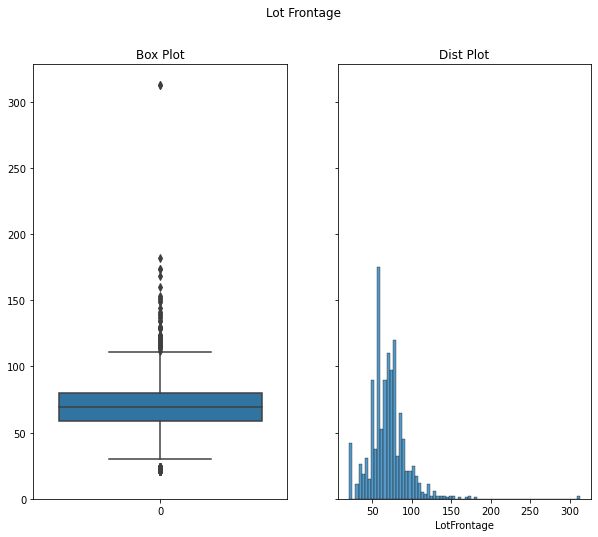

In [9]:
#Using seaborn to plot LotFrontage

fig, axes = plt.subplots(1,2,figsize = (10,8), sharey = True)
fig.suptitle('Lot Frontage')

axes[0].set_title('Box Plot')
axes[1].set_title('Dist Plot')

sns.boxplot(ax=axes[0], data=housing_df['LotFrontage'])
sns.histplot(ax=axes[1], data =housing_df['LotFrontage'])

Here, since the plot appears to be slighlty right-skewed it makes better sense to impute the values with the median rather than the mean, since the outliers will affect the mean

In [10]:
#Filling the column with median

housing_df['LotFrontage'] = housing_df['LotFrontage'].fillna(housing_df['LotFrontage'].median())

In [11]:
calc_missing_values()

-> MasVnrType, Missing: 8 (0.5%)
-> MasVnrArea, Missing: 8 (0.5%)
-> Electrical, Missing: 1 (0.1%)
-> GarageYrBlt, Missing: 81 (5.5%)


Thus, the Lot Frontage imputation is done.

#### MasVnrType and MasVnrArea

For the masonry veneer type and area, the rows which are NA also have a lot of the additional feature variables such as PoolQC, Fence and Misc Features as None, so I can safely assume the Masonry veneer type to be none as well. Hence, imputing these as None and 0 respectively.


In [12]:
# Replacing NA with None

housing_df['MasVnrType'] = housing_df['MasVnrType'].fillna('None')
housing_df['MasVnrArea'] = housing_df['MasVnrArea'].fillna(0)

calc_missing_values()

-> Electrical, Missing: 1 (0.1%)
-> GarageYrBlt, Missing: 81 (5.5%)


#### Electrical

Since there is only one missing values, imputing it with mode



In [13]:
housing_df['Electrical'] = housing_df['Electrical'].fillna(str(housing_df['Electrical'].mode()))
calc_missing_values()

-> GarageYrBlt, Missing: 81 (5.5%)


#### Garage Year Built

In [14]:
housing_df['GarageYrBlt'].value_counts()

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1927.0     1
1900.0     1
1906.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

Since the Garage year built is a year column, it doesnt make sense to treat it as a numerical column. Also, all the NA values in the column correspond to those houses which do not have garages.<br/> Hence, I have to convert this column into a categorical one using time periods (year_start - year_end) with **None** as one of the categories.   

In [15]:
# Converting into categorical column based on year

def get_time_period(year):

  if pd.isna(year):
    return year
  
  else:
    year_start = (year//10)*10
    return str(int(year_start)) + "-" + str(int(year_start) + 10)

housing_df['GarageYrBlt'] = housing_df['GarageYrBlt'].map(get_time_period)

In [16]:
housing_df['GarageYrBlt'].value_counts()

2000-2010    399
1990-2000    196
1970-1980    186
1960-1970    185
1950-1960    151
1980-1990     95
1940-1950     55
1920-1930     51
1930-1940     41
1910-1920     14
1900-1910      3
2010-2020      3
Name: GarageYrBlt, dtype: int64

In [124]:
#Replacing all NA's with None

housing_df['GarageYrBlt'] = housing_df['GarageYrBlt'].fillna('None')
calc_missing_values()

No missing values in dataframe


All the missing values in the dataset have now been handled

## **Data Analysis**

Heatmap to understand correlation

<AxesSubplot:>

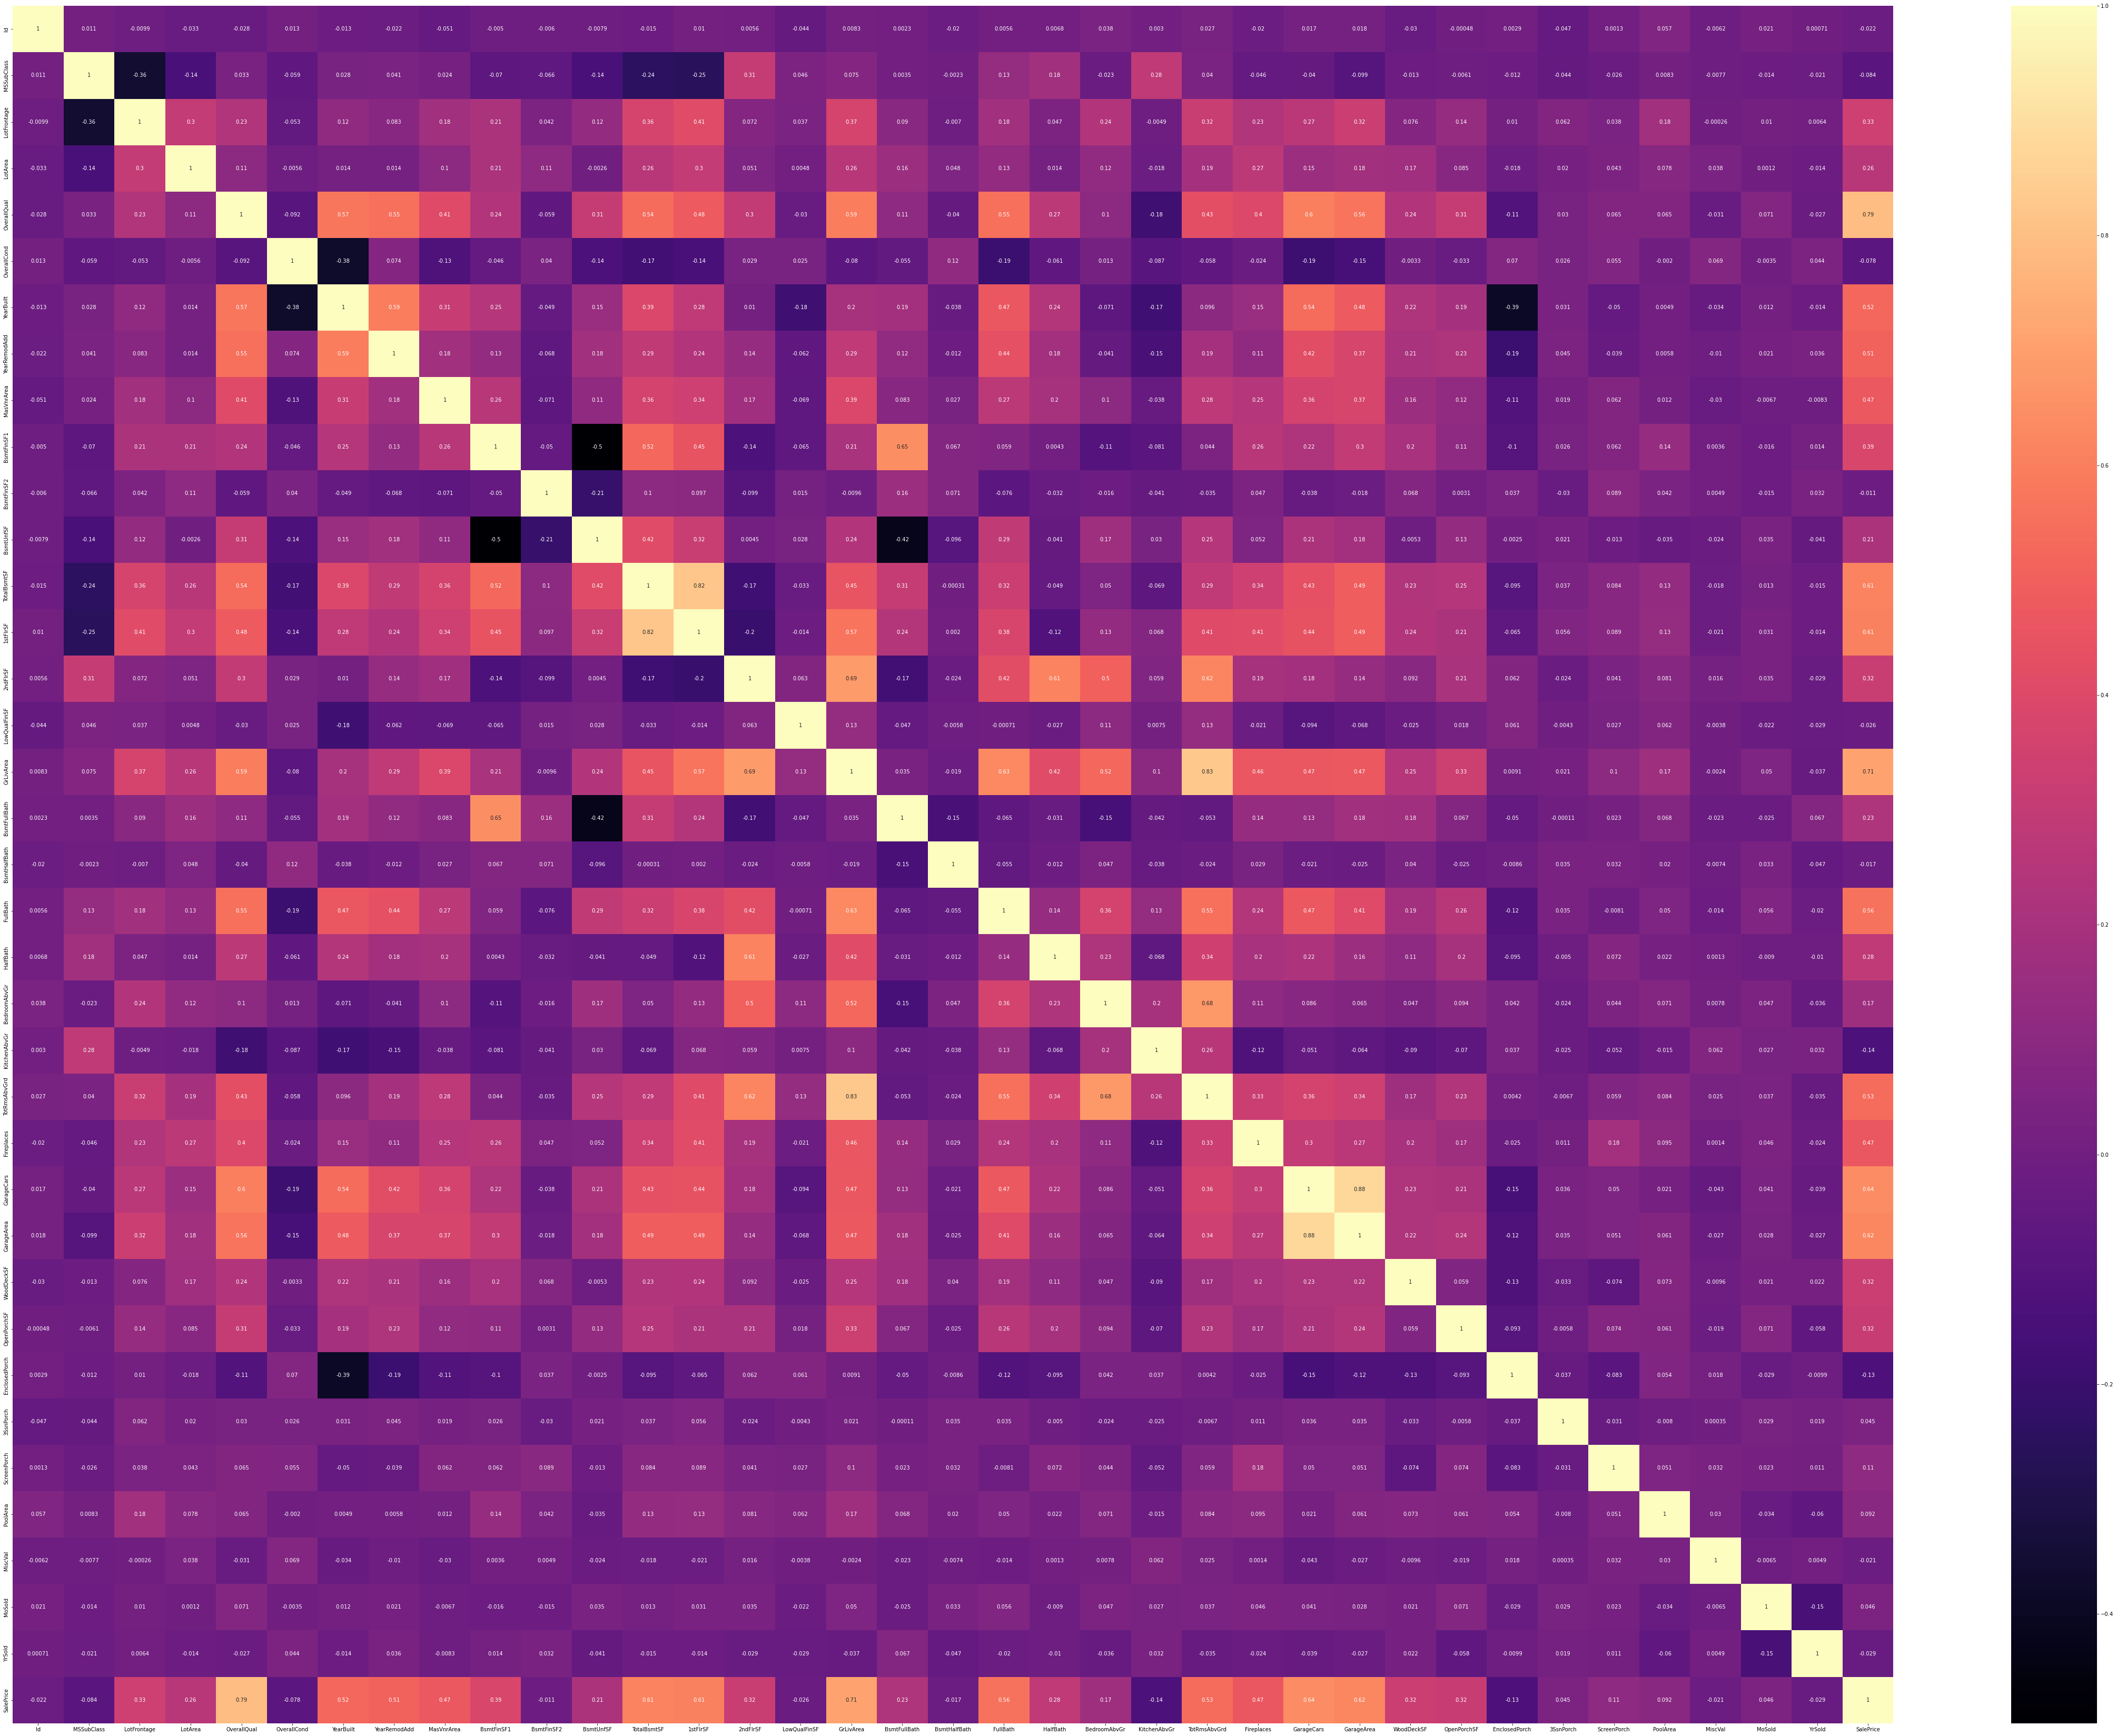

In [125]:
fig, ax = plt.subplots(figsize=(80,60))
sns.heatmap(housing_df.corr(), annot=True, cmap='magma', ax = ax)

Here, we can see that the highest influence on the target variable is due to Overall Quality and Gr Living Area.<br/><br/>

Also, the correlation coefficient for total rooms above grade and above grade living area are highly correlated, hence removing one of those. Since GrLivArea has a higher influence on the target variable, I will remove Total Rooms above grade.

In [17]:
housing_df = housing_df.drop('TotRmsAbvGrd', axis = 1)

#### Analysis of numerical variables

In [18]:
#Getting all the numeric variables out

housing_df_numeric = housing_df.select_dtypes(include=[np.number])

##Remove Id as it is not relevant
housing_df_numeric = housing_df_numeric.drop('Id', axis=1)

housing_df_numeric.shape

(1460, 35)

C:\Users\Aditya\anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


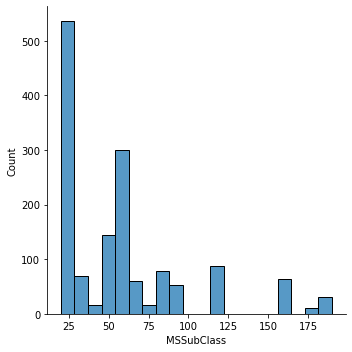

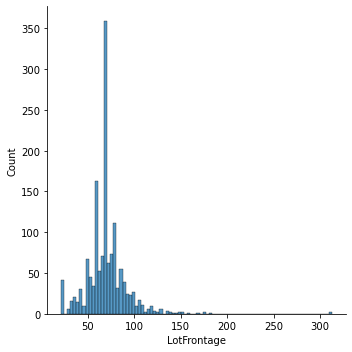

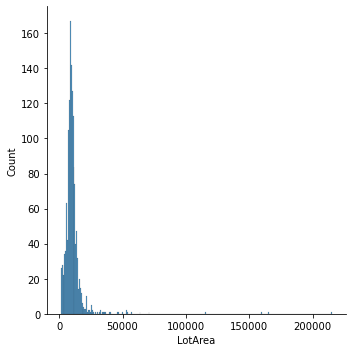

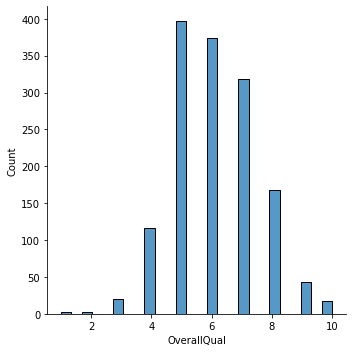

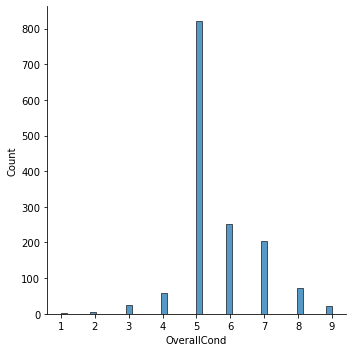

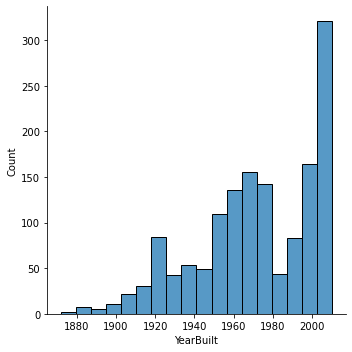

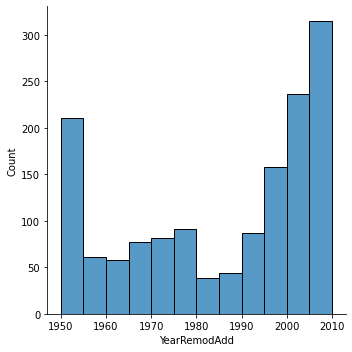

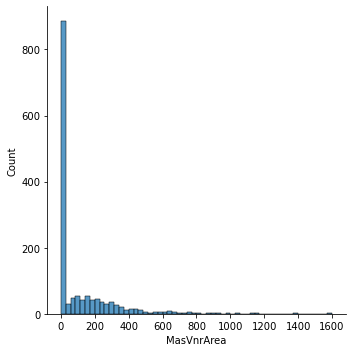

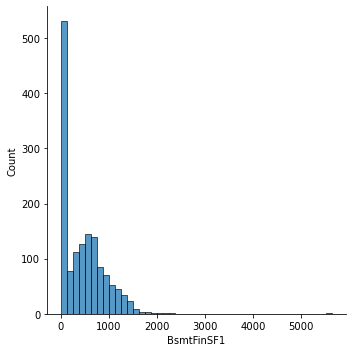

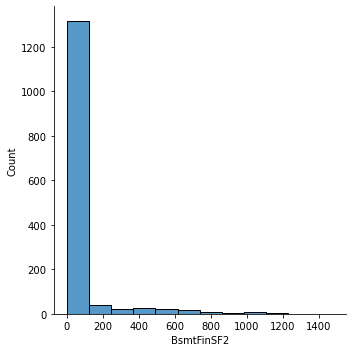

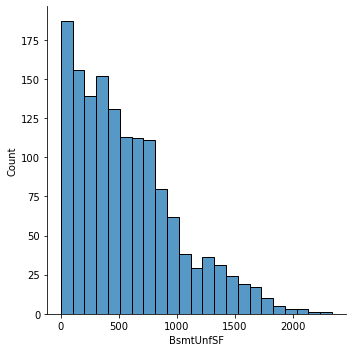

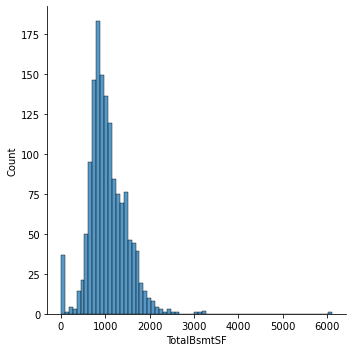

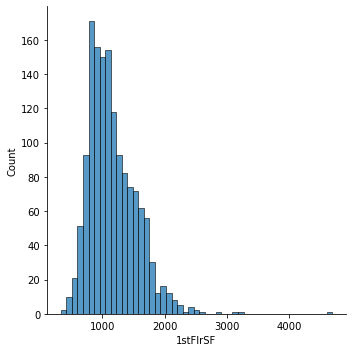

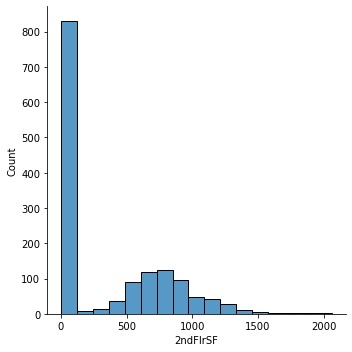

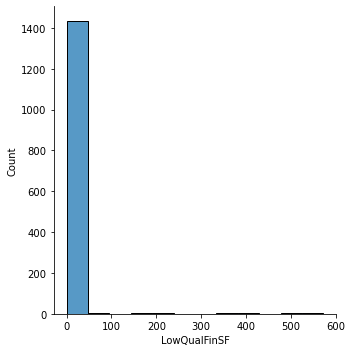

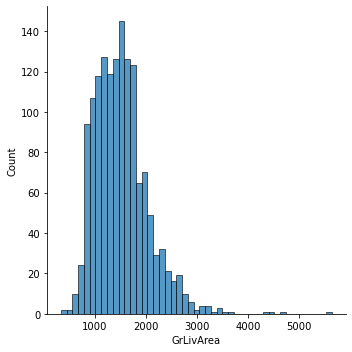

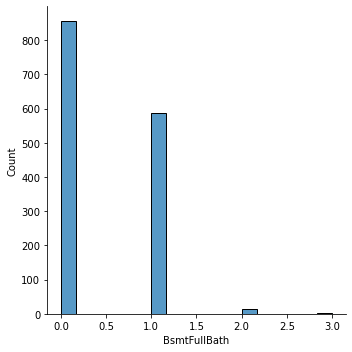

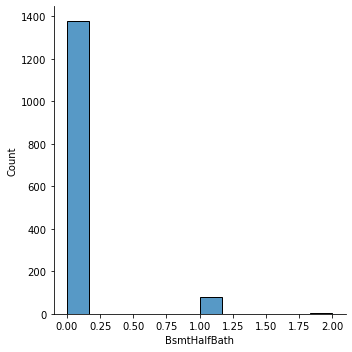

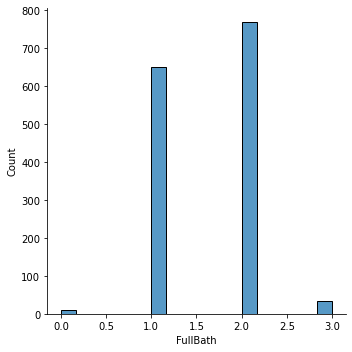

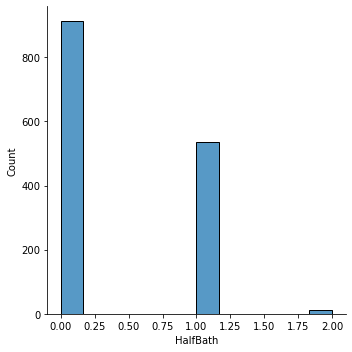

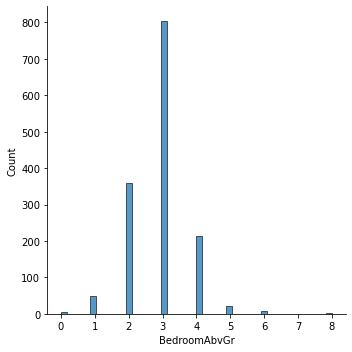

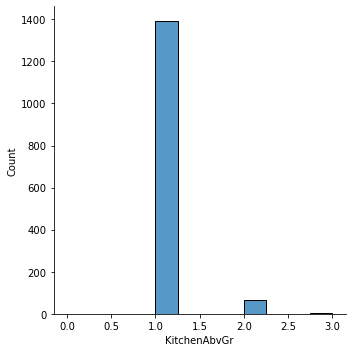

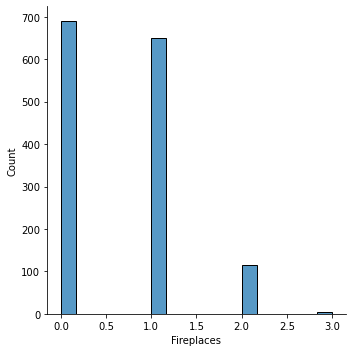

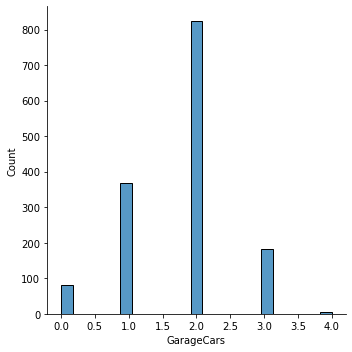

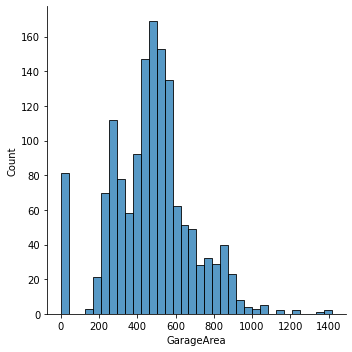

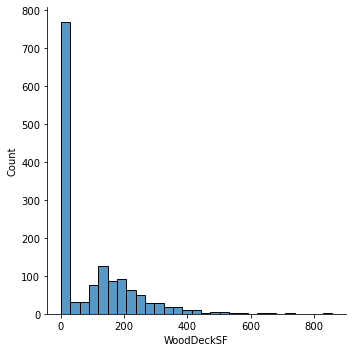

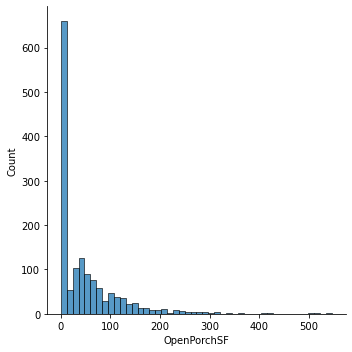

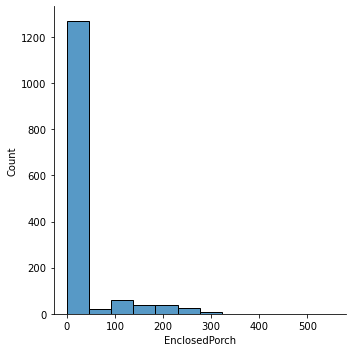

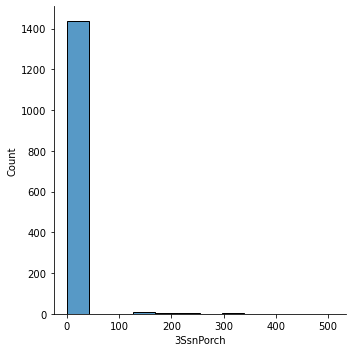

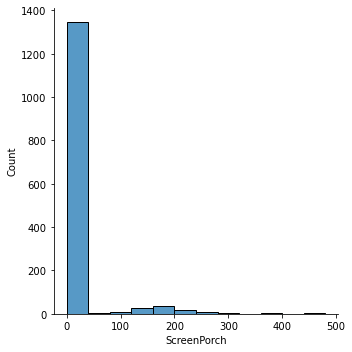

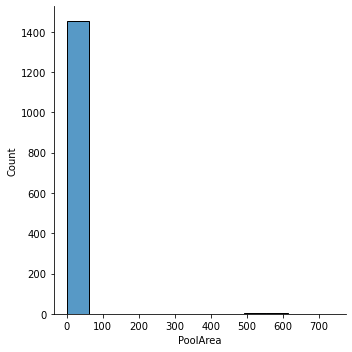

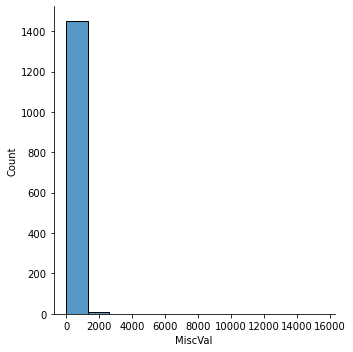

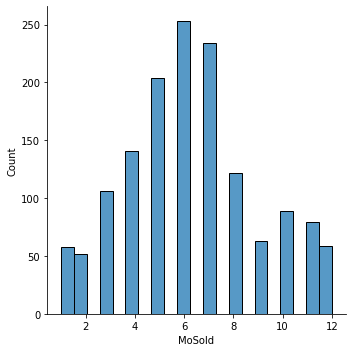

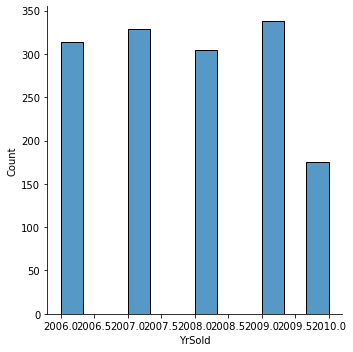

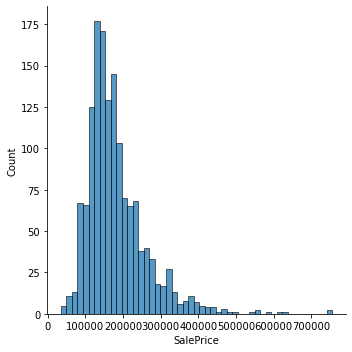

In [133]:
#Using bar plots to study distribution

for col in housing_df_numeric.columns:
    sns.displot(data = housing_df_numeric[col])

It can be seen that all the numeric variables are slightly skewed to the right, however there aren't any outright outliers in the dataset

C:\Users\Aditya\anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


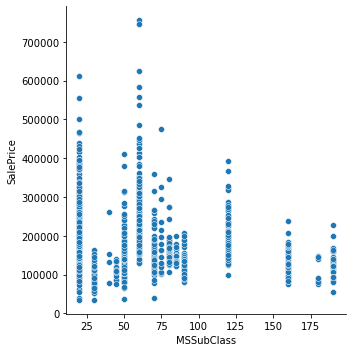

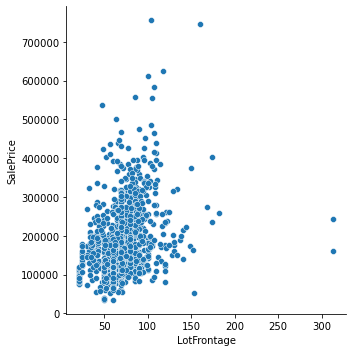

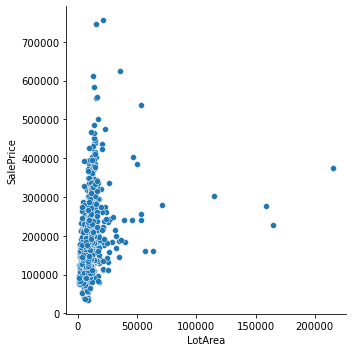

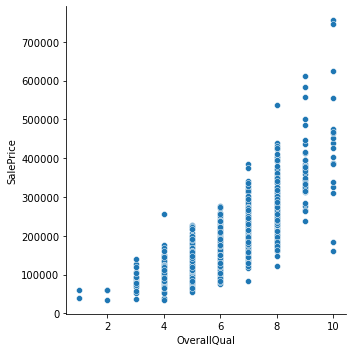

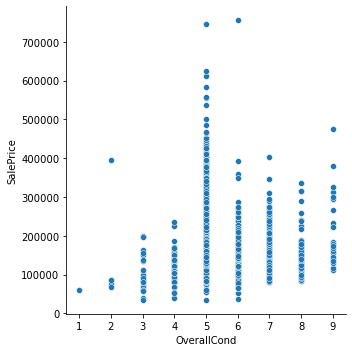

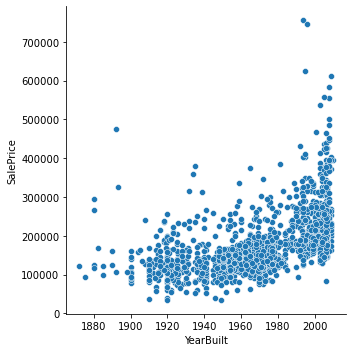

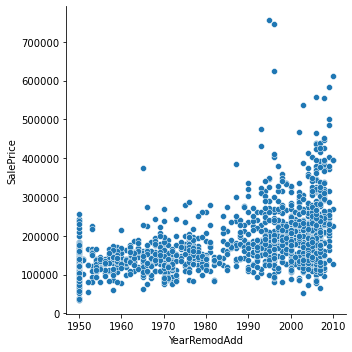

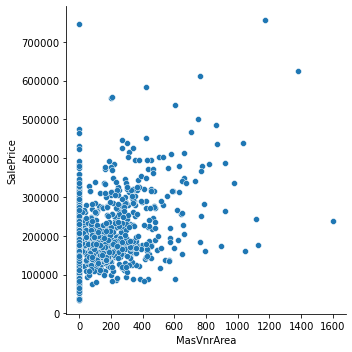

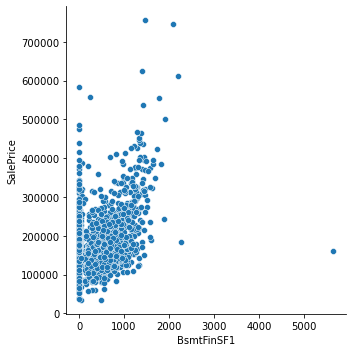

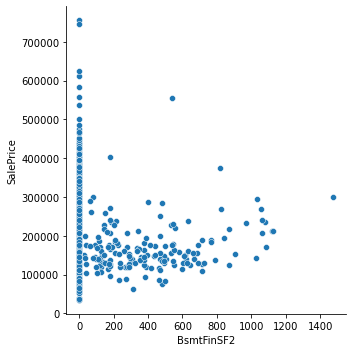

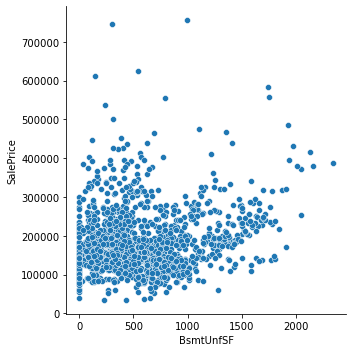

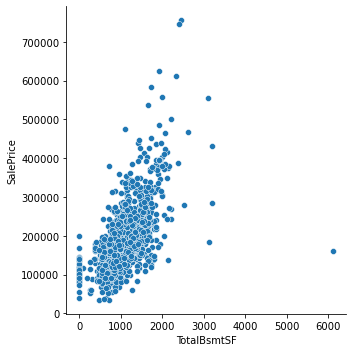

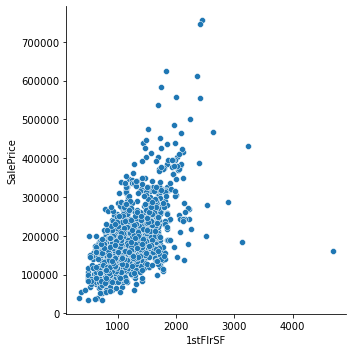

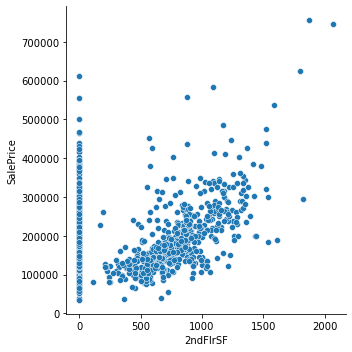

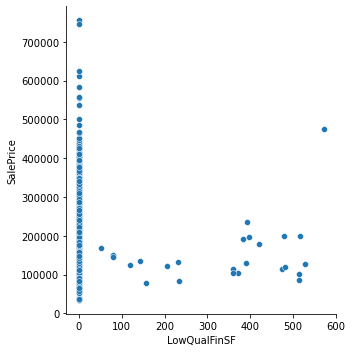

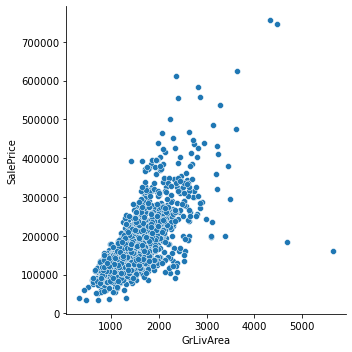

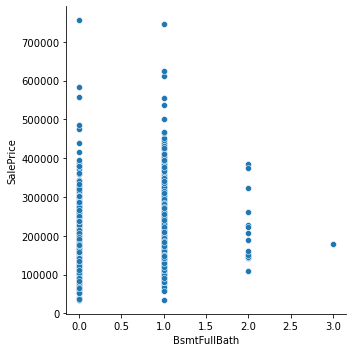

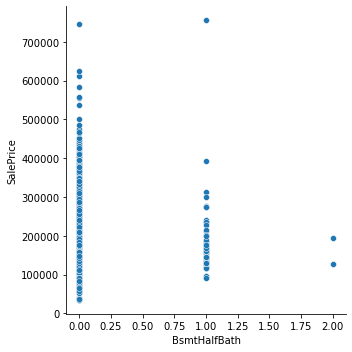

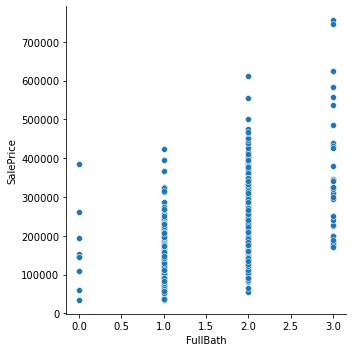

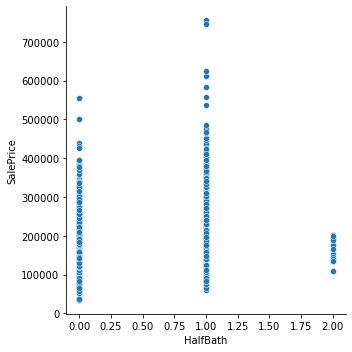

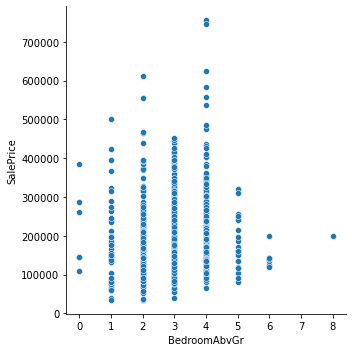

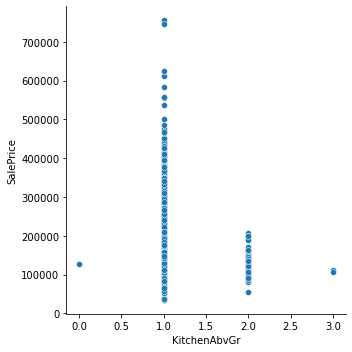

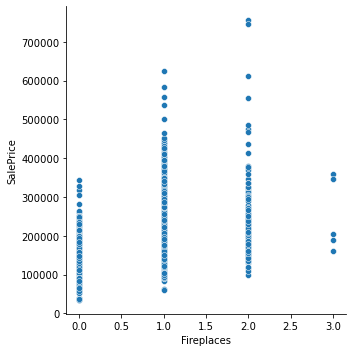

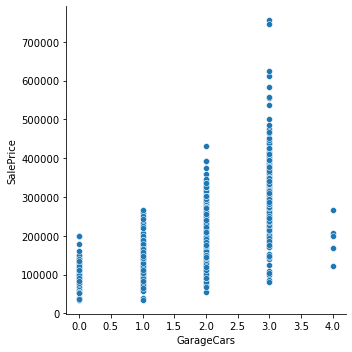

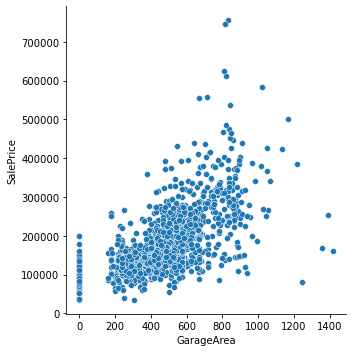

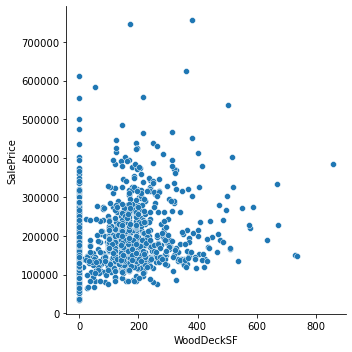

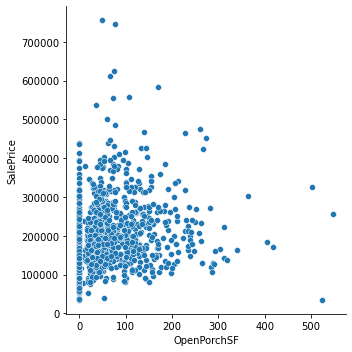

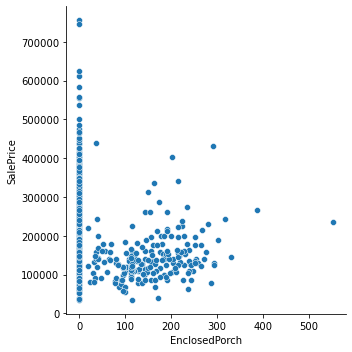

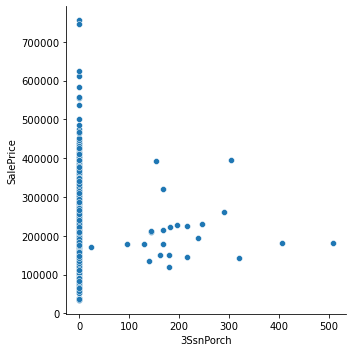

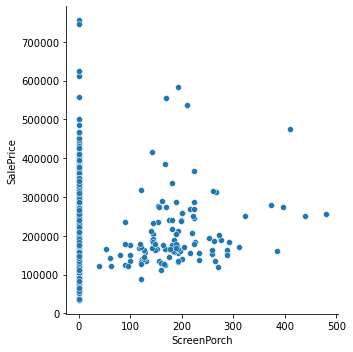

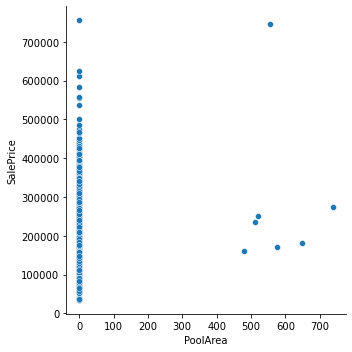

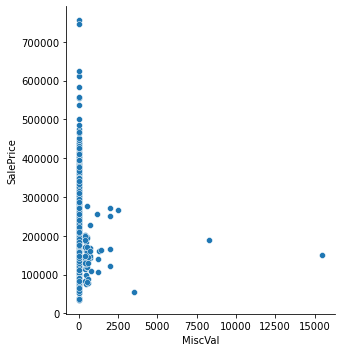

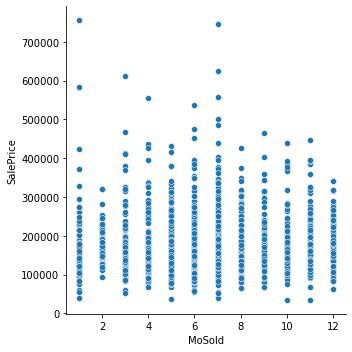

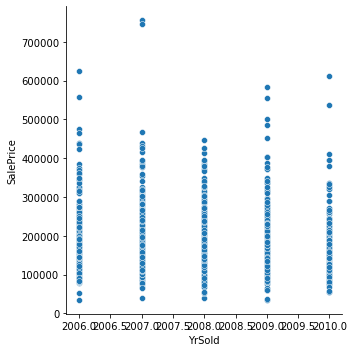

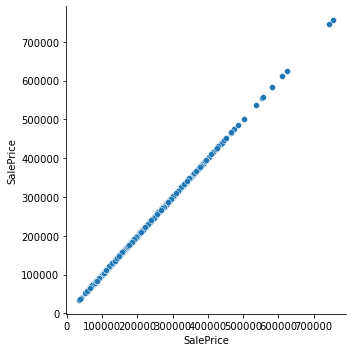

In [134]:
#Plotting the numerical variables vs sale price

for col in housing_df_numeric.columns:
    sns.relplot(x = housing_df_numeric[col], y = housing_df_numeric['SalePrice'], kind = 'scatter')
    

#### Categorical variables

In [19]:
#Getting categorical variables

housing_df_cat = housing_df.select_dtypes(exclude=[np.number])

housing_df_cat.shape

(1460, 44)

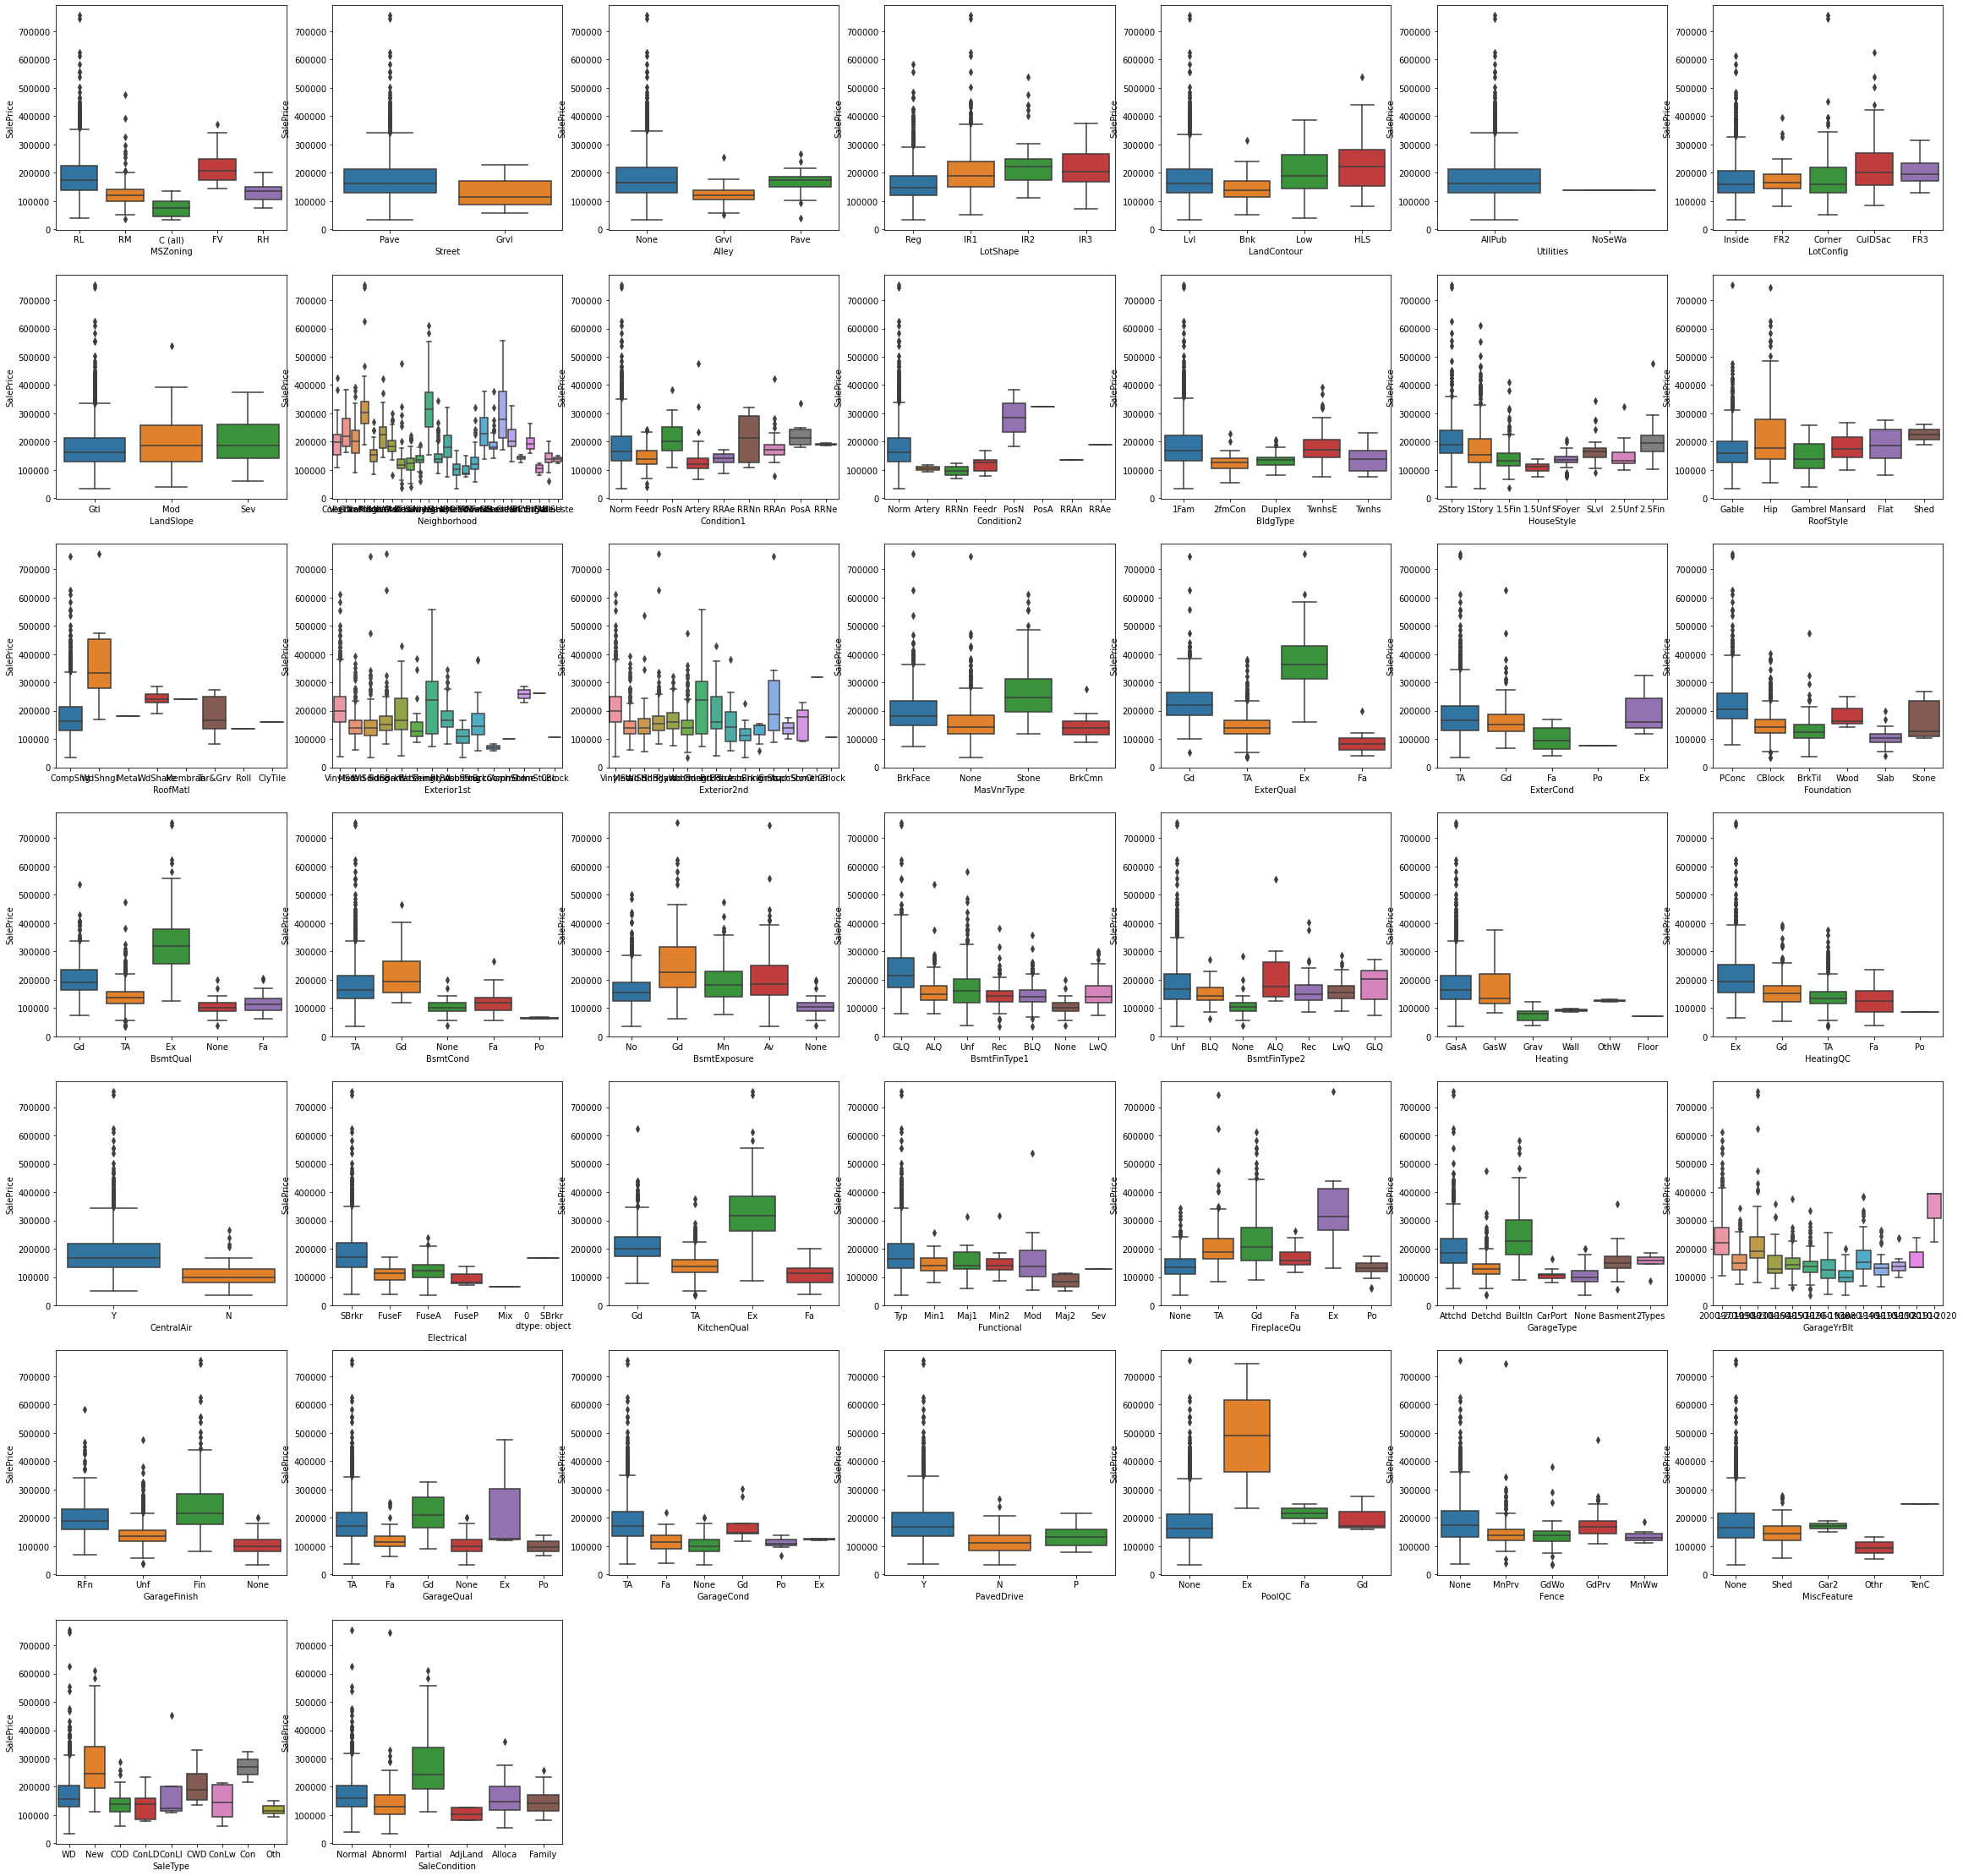

In [136]:
#Plotting them using box plots

plt.figure(figsize=(40,40))

for i, col in enumerate(housing_df_cat.columns, 1):
    plt.subplot(7,7,i)
    sns.boxplot(x = col, y = 'SalePrice', data = housing_df)

As we can see, all the columns - both numeric and categorical - contain a lot of outliers, which we will remove using quantiles

## Standard Linear Regression with RFE

Firstly, getting dummies for all the categorical variables in the dataset

In [49]:
#Get dummies for all the categorical columns

housing_df_cat = housing_df.select_dtypes(exclude=[np.number])

housing_df_final = pd.concat([housing_df, pd.get_dummies(data=housing_df_cat, columns = housing_df_cat.columns, drop_first=True).astype(np.int8)], axis = 1)

housing_df_final.drop(housing_df_cat.columns, axis=1, inplace=True)

housing_df_final.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,1,0


In [50]:
#Drop the Id column

housing_df_final = housing_df_final.drop('Id', axis=1)

housing_df_final.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,0.003425,0.003425,0.083562,0.002055,0.867808,0.002740,0.008219,0.013699,0.820548,0.085616
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,0.058440,0.058440,0.276824,0.045299,0.338815,0.052289,0.090317,0.116277,0.383862,0.279893
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Scaling

Scaling the features using normalization since the distribution of data is not uniform, which will help in our lasso and ridge regression later



In [51]:
# Split into input and target variables

y = housing_df_final.pop('SalePrice')
X = housing_df_final

print(X.shape)
print(y.shape)

#Split into test and train data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#Apply Scaling

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

num_cols = X_train.select_dtypes(include=[np.number]).columns

X_train[num_cols] = x_scaler.fit_transform(X_train[num_cols])
y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))


print(X_train.head())
print(y_train)

(1460, 269)
(1460,)
      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
64      0.235294     0.164384  0.037743     0.666667         0.50   0.905797   
682     0.588235     0.164384  0.007418     0.555556         0.50   0.898551   
960     0.000000     0.099315  0.027610     0.444444         0.75   0.623188   
1384    0.176471     0.133562  0.036271     0.555556         0.50   0.485507   
1100    0.058824     0.133562  0.033186     0.111111         0.50   0.347826   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
64        0.800000    0.358125    0.326991         0.0  ...             0.0   
682       0.783333    0.000000    0.443805         0.0  ...             0.0   
960       0.966667    0.000000    0.307965         0.0  ...             0.0   
1384      0.000000    0.000000    0.090265         0.0  ...             0.0   
1100      0.000000    0.000000    0.128319         0.0  ...             0.0   

      SaleType_ConLw  Sa

C:\Users\Aditya\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


## Linear Regression with RFE

In [52]:
# Linear Regression using sklearn

regressor = LinearRegression()

regressor.fit(X_train, y_train)

#Perform RFE with cross validation for selecting features

rfe = RFECV(regressor, step=1)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('MSSubClass', False, 29),
 ('LotFrontage', True, 1),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 91),
 ('MasVnrArea', True, 1),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', False, 10),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 75),
 ('BsmtHalfBath', False, 78),
 ('FullBath', False, 37),
 ('HalfBath', False, 159),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('Fireplaces', False, 142),
 ('GarageCars', False, 184),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 77),
 ('OpenPorchSF', False, 76),
 ('EnclosedPorch', False, 95),
 ('3SsnPorch', False, 141),
 ('ScreenPorch', False, 65),
 ('PoolArea', False, 54),
 ('MiscVal', False, 177),
 ('MoSold', False, 169),
 ('YrSold', False, 191),
 ('MSZoning_FV', False, 22),
 ('MSZoning_RH', False, 26),
 ('MSZoning_RL', False

In [53]:
# Creating X_train dataframe with RFE selected variables
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]

In [54]:
# Linear Regression using sklearn

regressor = LinearRegression()

regressor.fit(X_train_rfe, y_train)

#predict on training set to get training r2 score
y_pred = regressor.predict(X_train_rfe)

#Calculate R2 score
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

#print out our score properly formatted as a percent.
print("Training R^2 score:", score*100)
print("Training MSE", mse)

Training R^2 score: 91.37739258147235
Training MSE 0.0010142977669437613


In [55]:
##Checking VIF

def calc_vif():
    
    vif = pd.DataFrame()
    X = X_train_rfe
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

calc_vif()

C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
32,Exterior2nd_CBlock,inf
31,Exterior1st_CBlock,inf
6,BsmtFinSF1,inf
7,BsmtFinSF2,inf
8,BsmtUnfSF,inf
9,TotalBsmtSF,inf
23,RoofMatl_CompShg,2569.88
46,GarageCond_TA,223.65
12,GrLivArea,208.31
11,2ndFlrSF,148.69


Here, there exists a perfect multicollinearity between the basement variables, so we can remove the total basement sf as it will be a sum of all the previous basement variables

In [56]:
X_train = X_train.drop('TotalBsmtSF', axis = 1)
X_train_rfe = X_train_rfe.drop('TotalBsmtSF', axis = 1)

#Recalculate VIF

calc_vif()

C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
31,Exterior2nd_CBlock,inf
30,Exterior1st_CBlock,inf
22,RoofMatl_CompShg,2569.88
45,GarageCond_TA,223.65
11,GrLivArea,208.31
10,2ndFlrSF,148.69
41,GarageQual_TA,147.81
9,1stFlrSF,109.56
42,GarageCond_Fa,72.11
38,GarageQual_Fa,55.61


In [57]:
#Removing Exterior2nd_CBlock

X_train = X_train.drop('Exterior2nd_CBlock', axis = 1)
X_train_rfe = X_train_rfe.drop('Exterior2nd_CBlock', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
22,RoofMatl_CompShg,2569.88
44,GarageCond_TA,223.65
11,GrLivArea,208.31
10,2ndFlrSF,148.69
40,GarageQual_TA,147.81
9,1stFlrSF,109.56
41,GarageCond_Fa,72.11
37,GarageQual_Fa,55.61
36,GarageFinish_None,52.90
25,RoofMatl_Tar&Grv,24.57


In [58]:
#Removing RoofMatl_CompShg

X_train = X_train.drop('RoofMatl_CompShg', axis = 1)
X_train_rfe = X_train_rfe.drop('RoofMatl_CompShg', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
43,GarageCond_TA,2113.88
39,GarageQual_TA,1462.04
11,GrLivArea,1245.77
45,PoolQC_None,646.32
9,1stFlrSF,615.78
10,2ndFlrSF,233.83
15,Street_Pave,218.73
40,GarageCond_Fa,65.19
36,GarageQual_Fa,57.37
2,OverallQual,49.55


In [59]:
# Removing GarageCond_TA

X_train = X_train.drop('GarageCond_TA', axis = 1)
X_train_rfe = X_train_rfe.drop('GarageCond_TA', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
11,GrLivArea,1182.38
9,1stFlrSF,584.66
44,PoolQC_None,531.99
39,GarageQual_TA,389.26
10,2ndFlrSF,221.78
15,Street_Pave,216.78
2,OverallQual,49.12
4,YearBuilt,44.05
13,KitchenAbvGr,30.02
12,BedroomAbvGr,28.13


In [60]:
# Removing GrLivArea

X_train = X_train.drop('GrLivArea', axis = 1)
X_train_rfe = X_train_rfe.drop('GrLivArea', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
43,PoolQC_None,521.37
38,GarageQual_TA,387.15
14,Street_Pave,213.08
2,OverallQual,48.75
4,YearBuilt,43.73
12,KitchenAbvGr,30.02
11,BedroomAbvGr,27.93
9,1stFlrSF,26.28
30,ExterQual_TA,24.48
3,OverallCond,24.34


In [61]:
# Removing PoolQC_None

X_train = X_train.drop('PoolQC_None', axis = 1)
X_train_rfe = X_train_rfe.drop('PoolQC_None', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
38,GarageQual_TA,208.27
14,Street_Pave,190.20
2,OverallQual,48.39
4,YearBuilt,42.14
12,KitchenAbvGr,29.41
11,BedroomAbvGr,27.90
9,1stFlrSF,26.27
30,ExterQual_TA,24.26
3,OverallCond,23.70
13,GarageArea,16.11


In [62]:
# Removing GarageQual_TA

X_train = X_train.drop('GarageQual_TA', axis = 1)
X_train_rfe = X_train_rfe.drop('GarageQual_TA', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
14,Street_Pave,109.41
2,OverallQual,48.13
4,YearBuilt,39.10
12,KitchenAbvGr,27.90
11,BedroomAbvGr,27.79
9,1stFlrSF,26.26
30,ExterQual_TA,23.89
3,OverallCond,22.91
13,GarageArea,15.79
8,BsmtUnfSF,13.02


In [63]:
# Removing Street_Pave

X_train = X_train.drop('Street_Pave', axis = 1)
X_train_rfe = X_train_rfe.drop('Street_Pave', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
2,OverallQual,44.91
4,YearBuilt,34.73
11,BedroomAbvGr,27.72
9,1stFlrSF,26.26
12,KitchenAbvGr,24.09
3,OverallCond,20.32
29,ExterQual_TA,19.14
13,GarageArea,15.78
8,BsmtUnfSF,13.00
28,ExterQual_Gd,10.56


In [64]:
# Removing OverallQual

X_train = X_train.drop('OverallQual', axis = 1)
X_train_rfe = X_train_rfe.drop('OverallQual', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
3,YearBuilt,27.65
10,BedroomAbvGr,27.54
8,1stFlrSF,25.68
11,KitchenAbvGr,24.05
28,ExterQual_TA,19.13
2,OverallCond,17.86
12,GarageArea,15.66
7,BsmtUnfSF,12.16
27,ExterQual_Gd,10.46
5,BsmtFinSF1,9.37


In [65]:
# Removing YearBuilt

X_train = X_train.drop('YearBuilt', axis = 1)
X_train_rfe = X_train_rfe.drop('YearBuilt', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
9,BedroomAbvGr,26.98
7,1stFlrSF,25.09
10,KitchenAbvGr,22.92
27,ExterQual_TA,18.07
2,OverallCond,17.61
11,GarageArea,14.96
6,BsmtUnfSF,11.62
26,ExterQual_Gd,9.31
4,BsmtFinSF1,8.72
0,LotFrontage,8.66


In [66]:
# Removing BedroomAbvGr

X_train = X_train.drop('BedroomAbvGr', axis = 1)
X_train_rfe = X_train_rfe.drop('BedroomAbvGr', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
7,1stFlrSF,23.57
9,KitchenAbvGr,21.60
2,OverallCond,17.55
26,ExterQual_TA,17.38
10,GarageArea,14.85
6,BsmtUnfSF,11.50
25,ExterQual_Gd,9.21
4,BsmtFinSF1,8.71
0,LotFrontage,8.25
28,BsmtQual_TA,7.32


In [67]:
# Removing 1stFlrSF

X_train = X_train.drop('1stFlrSF', axis = 1)
X_train_rfe = X_train_rfe.drop('1stFlrSF', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
8,KitchenAbvGr,20.57
2,OverallCond,17.55
25,ExterQual_TA,17.35
9,GarageArea,14.46
24,ExterQual_Gd,9.21
0,LotFrontage,8.11
27,BsmtQual_TA,6.88
6,BsmtUnfSF,6.48
26,BsmtQual_Gd,5.69
4,BsmtFinSF1,5.22


In [68]:
# Removing KitchenAbvGr

X_train = X_train.drop('KitchenAbvGr', axis = 1)
X_train_rfe = X_train_rfe.drop('KitchenAbvGr', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
2,OverallCond,17.13
24,ExterQual_TA,14.39
8,GarageArea,13.83
23,ExterQual_Gd,8.36
0,LotFrontage,8.02
26,BsmtQual_TA,6.88
6,BsmtUnfSF,6.16
25,BsmtQual_Gd,5.68
4,BsmtFinSF1,5.09
1,LotArea,3.28


In [69]:
# Removing OverallCond

X_train = X_train.drop('OverallCond', axis = 1)
X_train_rfe = X_train_rfe.drop('OverallCond', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
7,GarageArea,13.31
23,ExterQual_TA,11.48
0,LotFrontage,7.98
22,ExterQual_Gd,7.24
25,BsmtQual_TA,6.37
5,BsmtUnfSF,6.12
24,BsmtQual_Gd,5.61
3,BsmtFinSF1,5.03
1,LotArea,3.28
6,2ndFlrSF,2.29


In [70]:
# Removing GarageArea

X_train = X_train.drop('GarageArea', axis = 1)
X_train_rfe = X_train_rfe.drop('GarageArea', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
22,ExterQual_TA,10.58
0,LotFrontage,7.52
21,ExterQual_Gd,6.62
24,BsmtQual_TA,6.26
23,BsmtQual_Gd,5.58
5,BsmtUnfSF,5.09
3,BsmtFinSF1,4.03
1,LotArea,3.28
32,GarageCond_Po,2.28
29,GarageQual_Po,2.17


In [71]:
# Removing ExterQual_TA

X_train = X_train.drop('ExterQual_TA', axis = 1)
X_train_rfe = X_train_rfe.drop('ExterQual_TA', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
0,LotFrontage,6.94
5,BsmtUnfSF,4.90
3,BsmtFinSF1,3.77
22,BsmtQual_Gd,3.70
23,BsmtQual_TA,3.57
1,LotArea,3.28
21,ExterQual_Gd,2.51
31,GarageCond_Po,2.28
28,GarageQual_Po,2.16
6,2ndFlrSF,2.07


In [72]:
# Removing LotFrontage

X_train = X_train.drop('LotFrontage', axis = 1)
X_train_rfe = X_train_rfe.drop('LotFrontage', axis = 1)

#Recalculate VIF

calc_vif()

,Features,VIF
4,BsmtUnfSF,4.19
21,BsmtQual_Gd,3.63
22,BsmtQual_TA,3.36
2,BsmtFinSF1,3.15
0,LotArea,2.99
20,ExterQual_Gd,2.50
30,GarageCond_Po,2.28
27,GarageQual_Po,2.16
5,2ndFlrSF,1.98
1,MasVnrArea,1.86


I will keep a threshold of 5, so all these features will be kept in the final model

Rebuilding linear regression model

In [90]:
print(X_train_rfe.columns)

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'Utilities_NoSeWa', 'LandSlope_Sev', 'Neighborhood_Crawfor',
       'Neighborhood_NoRidge', 'Condition2_PosN', 'HouseStyle_2.5Fin',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'ExterQual_Gd',
       'BsmtQual_Gd', 'BsmtQual_TA', 'Heating_OthW', 'GarageFinish_None',
       'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageCond_Fa',
       'GarageCond_Gd', 'GarageCond_Po', 'PoolQC_Gd', 'SaleType_CWD',
       'SaleType_Con', 'SaleType_New'],
      dtype='object')


In [76]:
# Linear Regression using sklearn

regressor = LinearRegression()

regressor.fit(X_train_rfe, y_train)

#predict on training set to get training r2 score
y_pred = regressor.predict(X_train_rfe)

#Calculate R2 score
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

#print out our score properly formatted as a percent.
print("Training R^2 score:", score*100)
print("Training MSE", mse)

Training R^2 score: 82.69005492285606
Training MSE 0.0020362099055953858


In [ ]:
#Predict on our test set.

#Apply scaling
X_test[num_cols] = x_scaler.fit_transform(X_test[num_cols])
#y_test = y_scaler.transform(y_test.values.reshape(-1,1))

# Remove the rfe,eda and VIF eliminated variables
X_test_rfe = X_test[col]

vif_cols = ['TotRmsAbvGrd','TotalBsmtSF', 'Exterior2nd_CBlock', 'RoofMatl_CompShg', 'GarageCond_TA', 'GarageQual_TA', 'GrLivArea', 'PoolQC_None', 'Street_Pave', 'OverallQual', 'YearBuilt', 'BedroomAbvGr', '1stFlrSF', 'KitchenAbvGr', 'OverallCond', 'GarageArea', 'ExterQual_TA', 'LotFrontage']
X_test_rfe = X_test_rfe.drop(vif_cols, axis = 1)

In [96]:
# Dropping the vif columns from original test set without rfe for lasso and ridge
X_test = X_test.drop(vif_cols, axis = 1)

In [93]:
y_pred = regressor.predict(X_test_rfe)

In [94]:
#calculate the R^2 score
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

#print out our score properly formatted as a percent.
print("R^2 score:", str(round(score,4)*100)+"%")
print("MSE", mse)

R^2 score: 31.869999999999997%
MSE 0.00891933781951645


As we can see, the test r2 score here is really low which means it has overfit the data. Applying lasso and ridge regression to see the results - 

In [159]:
#Lasso regression

lambdas = [-5, -1, 1e-4, 1e-3, 1e-2, 1, 5]

def test_lambda(a):
    model_lasso = Lasso(alpha=a)
    model_lasso.fit(X_train, y_train) 
    pred_test_lasso = model_lasso.predict(X_test)
    new_score = r2_score(y_test, pred_test_lasso)
    new_mse = mean_squared_error(y_test, pred_test_lasso)
    print('LAMDA: {:.3f} R2 SCORE: {:.4f} new_score, {}'.format(a, new_score*100, new_mse))
    
    
for l in lamdas:
    test_lamda(l)

LAMDA: -5.000 R2 SCORE: -3724860509832447.0% new_score, 487674057213.3
LAMDA: -1.000 R2 SCORE: -148994417936335.44% new_score, 19506961966.9
LAMDA: 0.000 R2 SCORE: 69.06% new_score, 0.0
LAMDA: 0.001 R2 SCORE: 71.45% new_score, 0.0
LAMDA: 0.010 R2 SCORE: 40.589999999999996% new_score, 0.0
LAMDA: 1.000 R2 SCORE: -0.02% new_score, 0.0
LAMDA: 5.000 R2 SCORE: -0.02% new_score, 0.0


In [160]:
#Changing the rangge of alphas

lambdas = [1e-3, 5e-3, 9e-3]

for l in lambdas:
    test_lambda(l)

LAMDA: 0.001 R2 SCORE: 71.4486 new_score, 0.0037380654190871418
LAMDA: 0.005 R2 SCORE: 52.6733 new_score, 0.006196200350665474
LAMDA: 0.009 R2 SCORE: 42.2112 new_score, 0.007565945497308651


Therefore, the ideal value of lambda is 0.001

Applying ridge regression

In [141]:
alphas = [-5, -1, 1e-4, 1e-3, 1e-2, 1, 5]

def test_alpha_ridge(a):
    model_ridge = Ridge(alpha=a)
    model_ridge.fit(X_train, y_train) 
    pred_test_lasso = model_ridge.predict(X_test)
    new_score = r2_score(y_test, pred_test_lasso)
    new_mse = mean_squared_error(y_test, pred_test_lasso)
    print('ALPHA: {:.3f} R2 SCORE: {} new_score, {:.1f}'.format(a, new_score*100, new_mse))
    
    
for alpha in alphas:
    test_alpha_ridge(alpha)

ALPHA: -5.000 R2 SCORE: -33578.78809537538 new_score, 4.4
ALPHA: -1.000 R2 SCORE: -1077.2965755334335 new_score, 0.2
ALPHA: 0.000 R2 SCORE: 52.09691803393276 new_score, 0.0
ALPHA: 0.001 R2 SCORE: 52.1800192272586 new_score, 0.0
ALPHA: 0.010 R2 SCORE: 52.94721700605023 new_score, 0.0
ALPHA: 1.000 R2 SCORE: 71.5721300985353 new_score, 0.0
ALPHA: 5.000 R2 SCORE: 78.39890106164522 new_score, 0.0


In [161]:
# Changing the range of alphas

alphas = [5, 10, 50, 100]

for alpha in alphas:
    test_alpha_ridge(alpha)

ALPHA: 5.000 R2 SCORE: 78.39890106164522 new_score, 0.0
ALPHA: 10.000 R2 SCORE: 79.00344198811776 new_score, 0.0
ALPHA: 50.000 R2 SCORE: 74.74515690518314 new_score, 0.0
ALPHA: 100.000 R2 SCORE: 70.808127861712 new_score, 0.0


In [165]:
# Changing the range of alphas

alphas = [10, 15, 20, 25]

for alpha in alphas:
    test_alpha_ridge(alpha)

ALPHA: 10.000 R2 SCORE: 79.00344198811776 new_score, 0.0
ALPHA: 15.000 R2 SCORE: 78.66589409293204 new_score, 0.0
ALPHA: 20.000 R2 SCORE: 78.11664063327805 new_score, 0.0
ALPHA: 25.000 R2 SCORE: 77.51668576817721 new_score, 0.0


Therefore, the ideal value of alpha will be 10